In [1]:
import sys
import numpy as np
sys.path.append('..')
%load_ext autoreload
%autoreload 2

# jax config
from jax import config
config.update("jax_enable_x64", True)

# plotting
import matplotlib.pyplot as plt
import numpy as np
from opentn.utils import set_discrete_labels
from opentn.transformations import create_kitaev_liouvillians, create_trotter_layers, super2ortho

# structure preserving methods
from opentn.structure_preserving import unnormalized_scheme

# optimization
from opentn.optimization import frobenius_norm, model_stiefel_local, get_kitaev_trotter_local_ansatz

# stiefel
from opentn.stiefel import gradient_stiefel_vec, riemannian_hessian_vec, retract_stiefel
from opentn.trust_region_rcopt import riemannian_trust_region_optimize

# Let's do the same comparison for the kitaev wire. Let's say with $\tau = 1$ for now!

In [3]:
d, N, gamma = 2, 4, 1
Lvec, Lvec_odd, Lvec_even, Lnn = create_kitaev_liouvillians(N=N, d=d, gamma=gamma, pbc=True)

In [4]:
# testing the individual parts to see what is going on
from opentn.structure_preserving import effective_hamiltonian, composition, unnormalized_scheme_error
from opentn.transformations import super2choi
from opentn.stiefel import is_hermitian, is_isometry_2


h_eff = effective_hamiltonian(lindbladians=Lnn, N=N, d=d, pbc=True)
print(is_hermitian(h_eff)) # but when taking away the 1/j it is hermitian as expected.

# lets evaluate the conditions of the final superoperator
superop_unnormalized = unnormalized_scheme(lindbladians=Lnn, N=N, d=d, dt=1/1, order=1, quadrature='midpoint')
ortho = super2ortho(superop_unnormalized.real)
is_isometry_2(ortho)

(False, 1.3228756555322954)


False

In [5]:
superop_unnormalized_order_3 = unnormalized_scheme(lindbladians=Lnn, N=N, d=d, dt=1/1, order=3)
superop_unnormalized_order_3


Array([[1.        +0.j, 0.        +0.j, 0.        +0.j, ...,
        0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.88590495+0.j, 0.05533854+0.j, ...,
        0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.05533854+0.j, 0.88590495+0.j, ...,
        0.        +0.j, 0.        +0.j, 0.        +0.j],
       ...,
       [0.        +0.j, 0.        +0.j, 0.        +0.j, ...,
        0.88590495+0.j, 0.05533854+0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.        +0.j, ...,
        0.05533854+0.j, 0.88590495+0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.        +0.j, ...,
        0.        +0.j, 0.        +0.j, 1.        +0.j]],      dtype=complex128)

In [7]:
tau = 1
number_timesteps = list(range(1,20))
timesteps = [tau/n for n in number_timesteps]
error_order_1 = [unnormalized_scheme_error(Lvec, Lnn, N, d, tau=tau, n=n, order=1) for n in number_timesteps]
error_order_2 = [unnormalized_scheme_error(Lvec, Lnn, N, d, tau=tau, n=n, order=2) for n in number_timesteps]
error_order_3 = [unnormalized_scheme_error(Lvec, Lnn, N, d, tau=tau, n=n, order=3, verbose=True) for n in number_timesteps]

currently using tau=1, n=1, M=3
currently using tau=1, n=2, M=3
currently using tau=1, n=3, M=3
currently using tau=1, n=4, M=3
currently using tau=1, n=5, M=3
currently using tau=1, n=6, M=3
currently using tau=1, n=7, M=3
currently using tau=1, n=8, M=3
currently using tau=1, n=9, M=3
currently using tau=1, n=10, M=3
currently using tau=1, n=11, M=3
currently using tau=1, n=12, M=3
currently using tau=1, n=13, M=3
currently using tau=1, n=14, M=3
currently using tau=1, n=15, M=3
currently using tau=1, n=16, M=3
currently using tau=1, n=17, M=3
currently using tau=1, n=18, M=3
currently using tau=1, n=19, M=3


In [8]:
taus = np.logspace(start=2, stop=-9, num=12, base=2)[::-1]
error_order_1_taus = [unnormalized_scheme_error(Lvec, Lnn, N, d, tau=tau, n=1, order=1) for tau in taus]
error_order_2_taus = [unnormalized_scheme_error(Lvec, Lnn, N, d, tau=tau, n=1, order=2) for tau in taus]
error_order_3_taus = [unnormalized_scheme_error(Lvec, Lnn, N, d, tau=tau, n=1, order=3, verbose=True) for tau in taus[5:]]

currently using tau=0.0625, n=1, M=3
currently using tau=0.125, n=1, M=3
currently using tau=0.25, n=1, M=3
currently using tau=0.5, n=1, M=3
currently using tau=1.0, n=1, M=3
currently using tau=2.0, n=1, M=3
currently using tau=4.0, n=1, M=3


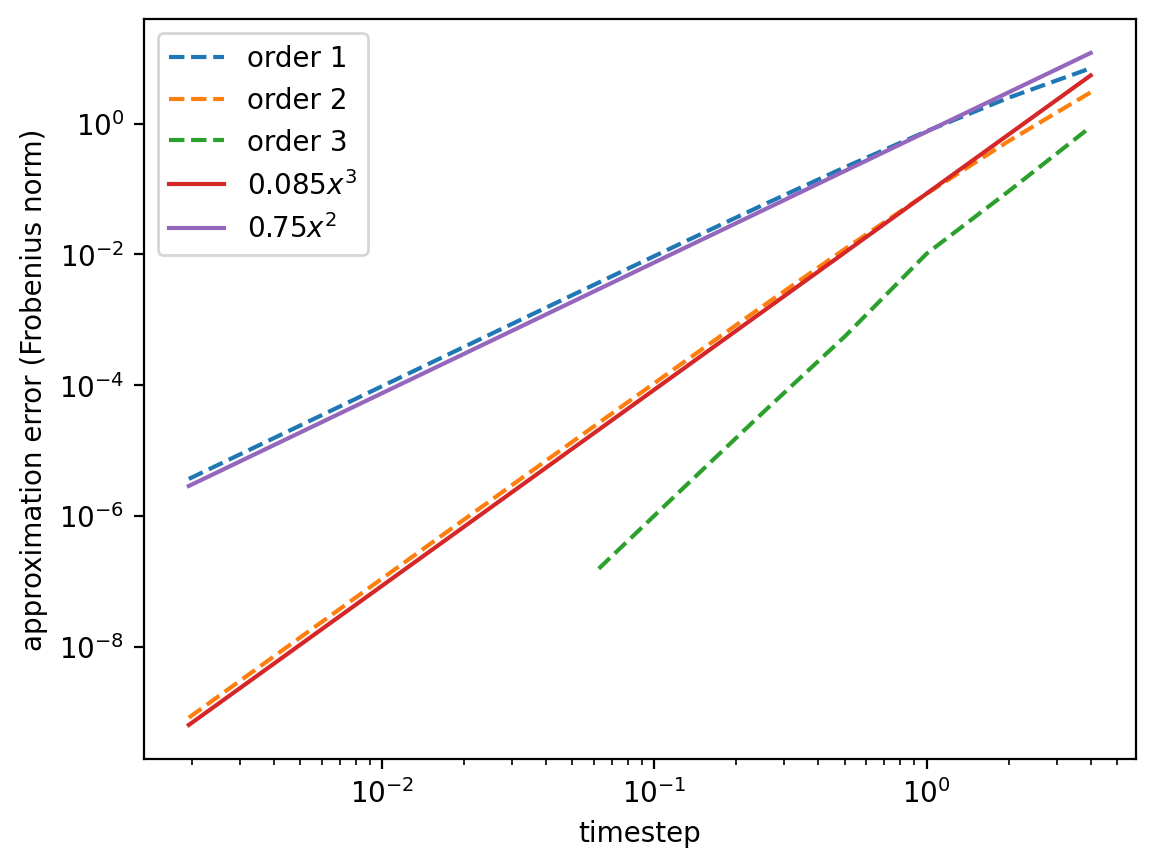

In [9]:
a  = 0.085
exponent = 3

b = 0.75
exponent_2 = 2
fig = plt.figure(dpi=200)
plt.ylabel('approximation error (Frobenius norm)')
plt.xlabel('timestep')
plt.loglog(taus, error_order_1_taus, '--', label='order 1')
plt.loglog(taus, error_order_2_taus, '--', label='order 2')
plt.loglog(taus[5:], error_order_3_taus, '--', label='order 3')
plt.loglog(taus, a*np.array(taus, dtype=float)**(exponent), label=fr'${a} x^{exponent}$')
plt.loglog(taus, b*np.array(taus, dtype=float)**(exponent_2), label=fr'${b} x^{exponent_2}$')
plt.legend()

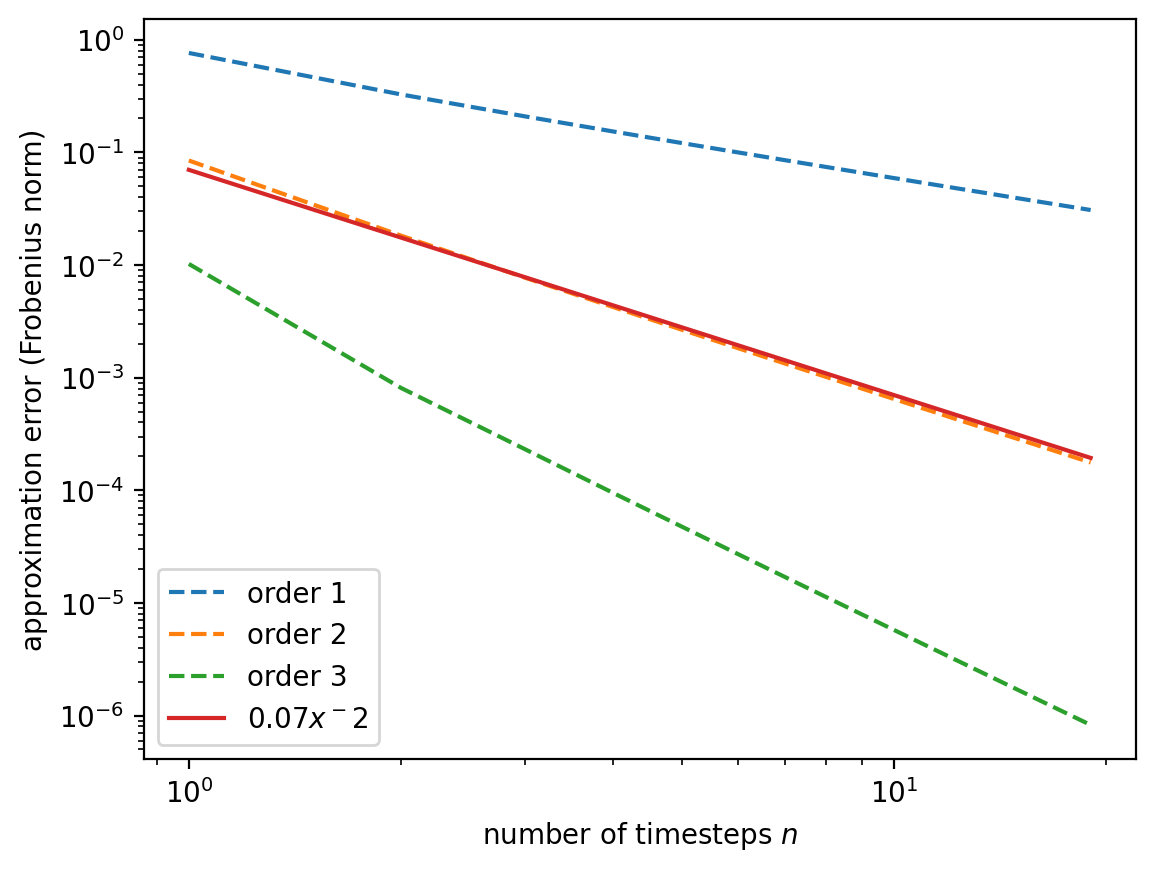

In [10]:
fig = plt.figure(dpi=200)
a = 0.07
exponent = -2
plt.ylabel('approximation error (Frobenius norm)')
plt.xlabel('number of timesteps $n$')
plt.loglog(number_timesteps, error_order_1, '--', label='order 1')
plt.loglog(number_timesteps, error_order_2, '--', label='order 2')
plt.loglog(number_timesteps, error_order_3, '--', label='order 3')
plt.loglog(number_timesteps, a*np.array(number_timesteps, dtype=float)**(exponent), label=fr'${a} x^{exponent}$')
plt.legend()

# Comparing with the stiefel optimized

In [11]:
exp_Lvec, exp_Lvec_odd, exp_Lvec_even = create_trotter_layers([Lvec, Lvec_odd, Lvec_even], tau=tau)
f_stiefel = lambda xi: frobenius_norm(model_stiefel_local(xi, N, d, ), exp_Lvec)
grad_stiefel = lambda xi: gradient_stiefel_vec(xi, f_stiefel, metric='canonical')
hessian_stiefel = lambda xi: riemannian_hessian_vec(xi, f_stiefel, metric='canonical')

In [13]:
xs_timestep_1_tau_1 = [super2ortho(x.real, rank=2) for x in get_kitaev_trotter_local_ansatz(gamma, tau, n=1)]
xs_timestep_1_tau_1_opt, f_timestep_1_tau_1_opt, radius_timestep_1_tau_1_opt = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_1_tau_1, save_x=False, niter=20
)

iteration: 0
column : 0
column : 1
column : 2
f(x0): 0.005992052805369189
rho: 0.6017851928016467 updated radius: 0.01
iteration: 1
column : 0
column : 1
column : 2
f(x1): 0.005179546089612317
rho: 0.9315825064186265 updated radius: 0.01
iteration: 2
column : 0
column : 1
column : 2
f(x2): 0.00496886996117253
rho: 0.9999251890922026 updated radius: 0.01
iteration: 3
column : 0
column : 1
column : 2
f(x3): 0.004967157117125347
rho: 0.9997019345757399 updated radius: 0.01
iteration: 4
column : 0
column : 1
column : 2
f(x4): 0.0049671571139104885
rho: 44009.768708347845 updated radius: 0.01
iteration: 5
column : 0
column : 1
column : 2
f(x5): 0.004967157113910482
rho: -132396.71512358452 updated radius: 0.0025
iteration: 6
column : 0
column : 1
column : 2
f(x6): 0.004967157113910482
rho: -132396.71512358452 updated radius: 0.000625
iteration: 7
column : 0
column : 1
column : 2
f(x7): 0.004967157113910482
rho: -132396.71512358452 updated radius: 0.00015625
iteration: 8
column : 0
column : 

In [14]:
xs_timestep_2_tau_1 = [super2ortho(x.real, rank=2) for x in get_kitaev_trotter_local_ansatz(gamma, tau, n=2)]
xs_timestep_2_tau_1_opt, f_timestep_2_tau_1_opt, radius_timestep_2_tau_1_opt = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_2_tau_1, save_x=False, niter=40)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
f(x0): 0.0015003228414406608
rho: 0.009234034496871765 updated radius: 0.0025
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
f(x1): 0.0015003228414406608
rho: 0.5726833828300993 updated radius: 0.0025
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
f(x2): 0.0012901493693791082
rho: 0.8416231936796468 updated radius: 0.005
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
f(x3): 0.001196972130768543
rho: 0.8357365432473555 updated radius: 0.01
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
f(x4): 0.0011487127266601046
rho: -2.310493522990995 updated radius: 0.0025
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
f(x5): 0.0011487127266601046
rho: 1.0742230001617126 updated radius: 0.005
iteration: 6
column : 0
column : 1
column : 2
column : 3
column : 4
f(x6): 0.001081383908025319
rho: 0.48415366384242636 updated radius: 0.

In [28]:
xs_timestep_3_tau_1 = [super2ortho(x.real, rank=2) for x in get_kitaev_trotter_local_ansatz(gamma, tau, n=3)]
xs_timestep_3_tau_1_opt, f_timestep_3_tau_1_opt, radius_timestep_3_tau_1_opt = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_3_tau_1, save_x=True, niter=40)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x0): 0.0006670002231766038
rho: -0.8458295874798131 updated radius: 0.0025
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x1): 0.0006670002231766038
rho: 0.5626077484691308 updated radius: 0.0025
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x2): 0.0005650859527180461
rho: 0.7207420126698779 updated radius: 0.0025
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x3): 0.0005094703967385343
rho: 0.9341894693623787 updated radius: 0.005
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x4): 0.00046665715503712223
rho: 0.46688911932768745 updated radius: 0.005
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x5): 0.0004412069523259432
rho: 0.8915642867764411 updated radius: 0.01
itera

In [31]:
xs_timestep_4_tau_1 = [super2ortho(x.real, rank=2) for x in get_kitaev_trotter_local_ansatz(gamma, tau, n=4)]
xs_timestep_4_tau_1_opt, f_timestep_4_tau_1_opt, radius_timestep_4_tau_1_opt = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_4_tau_1, save_x=False, niter=40)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
f(x0): 0.00037522504487494515
rho: -2.0730647338563952 updated radius: 0.0025
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
f(x1): 0.00037522504487494515
rho: 0.555121426783363 updated radius: 0.0025
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
f(x2): 0.0003078947245789204
rho: 0.6566521210336848 updated radius: 0.0025
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
f(x3): 0.0002704720324774185
rho: 0.8141776683481639 updated radius: 0.005
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
f(x4): 0.00023224232494117837
rho: -0.216138921898658 updated radius: 0.00125
iteration: 5
column : 0
column : 1
column : 2
column : 3


In [34]:
xs_timestep_5_tau_1 = [super2ortho(x.real, rank=2) for x in get_kitaev_trotter_local_ansatz(gamma, tau, n=5)]
xs_timestep_5_tau_1_opt, f_timestep_5_tau_1_opt, radius_timestep_5_tau_1_opt = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_5_tau_1, save_x=True, niter=20)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
column : 9
column : 10
f(x0): 0.00024015511328976018
rho: -3.045413748236838 updated radius: 0.0025
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
column : 9
column : 10
f(x1): 0.00024015511328976018
rho: 0.5111125305889355 updated radius: 0.0025
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
column : 9
column : 10
f(x2): 0.000193549335782335
rho: 0.5693385896073968 updated radius: 0.0025
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
column : 9
column : 10
f(x3): 0.00016255386620078716
rho: 0.5347541820630709 updated radius: 0.0025
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
column : 9
column : 10
f(x4): 0.0001354983

In [41]:
f_stiefel_ts = [f_timestep_1_tau_1_opt[:20], f_timestep_2_tau_1_opt[:25], f_timestep_3_tau_1_opt[:25], f_timestep_4_tau_1_opt[:25], f_timestep_5_tau_1_opt]
ratios_ts = []
for f_ts in f_stiefel_ts:
    ratios_ts.append([f/f_ts[0] for f in f_ts])

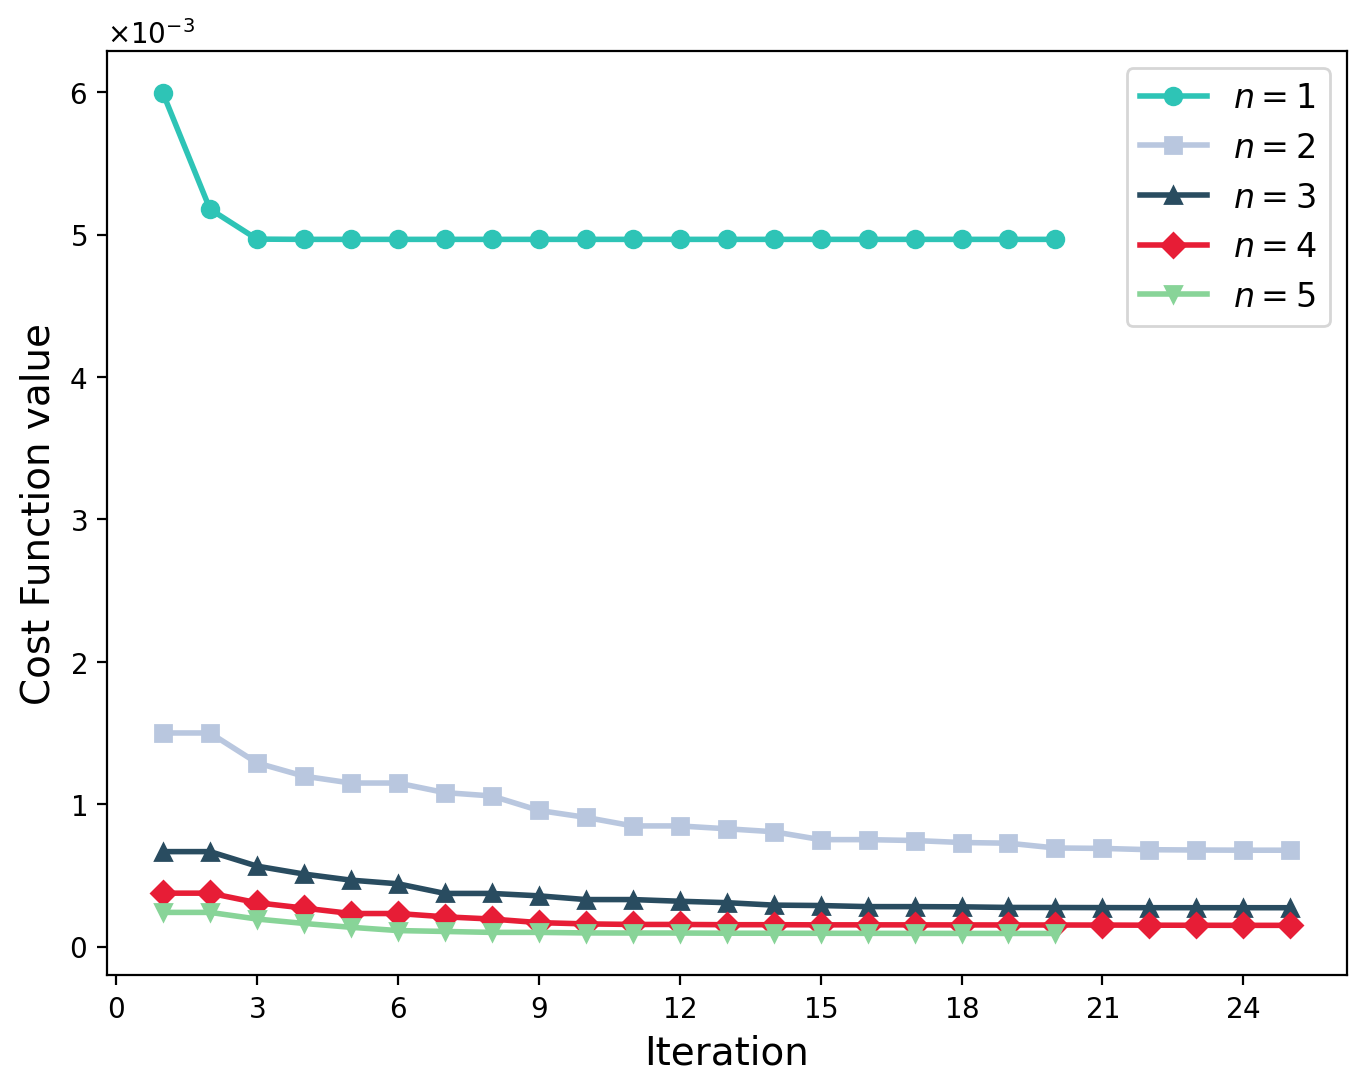

In [80]:
from opentn.utils import plot_pretty
labels = [rf"$n = {i}$" for i in range(1,len(f_stiefel_ts)+1)]
fig = plot_pretty(
    ydatas=f_stiefel_ts,
    labels=labels,
    ylabel="Cost Function value",
    xlabel="Iteration",
    integers=True,
    optimize=False,
    legend_out=False,
)

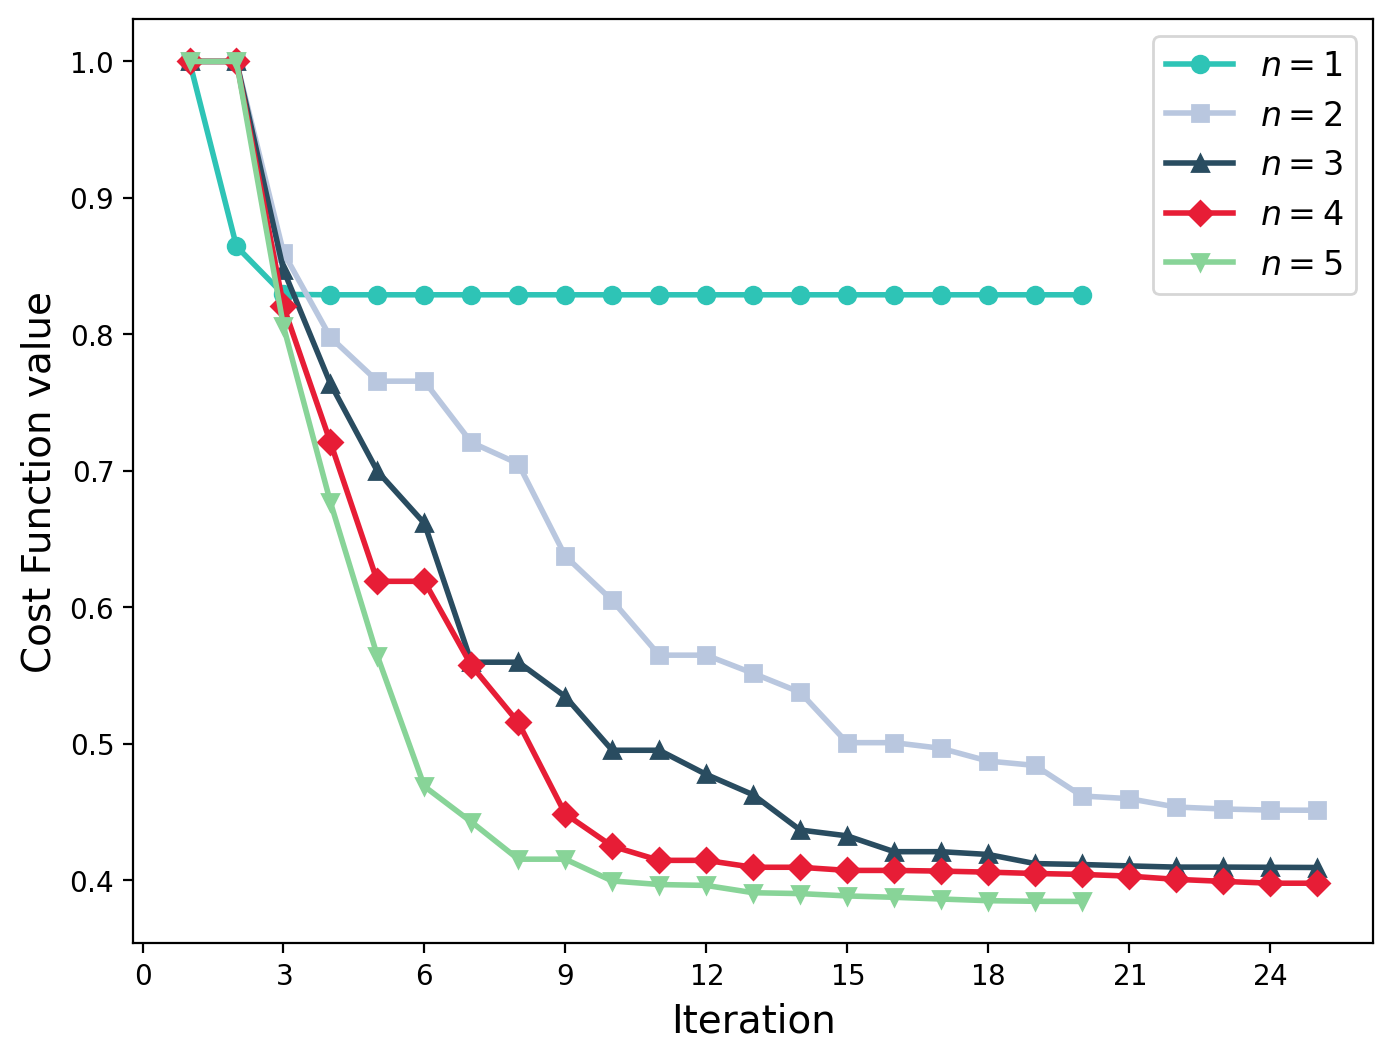

In [81]:
from opentn.utils import plot_pretty
labels = [rf"$n = {i}$" for i in range(1,len(ratios_ts)+1)]
fig = plot_pretty(
    ydatas=ratios_ts,
    labels=labels,
    ylabel="Cost Function value",
    xlabel="Iteration",
    integers=True,
    optimize=False,
    legend_out=False,
)
fig.savefig('../images/thesis/cost_kitaev_timesteps_convergence_scaled.pdf', bbox_inches='tight')

In [45]:
from opentn.optimization import compute_trotter_approximation_error
error_trotter = [compute_trotter_approximation_error(d, N, tau=tau, n=n, Li=[Lnn]) for n in range(1, 11)]
error_stiefel_tau_1 = [values[-1] for values in f_stiefel_ts]

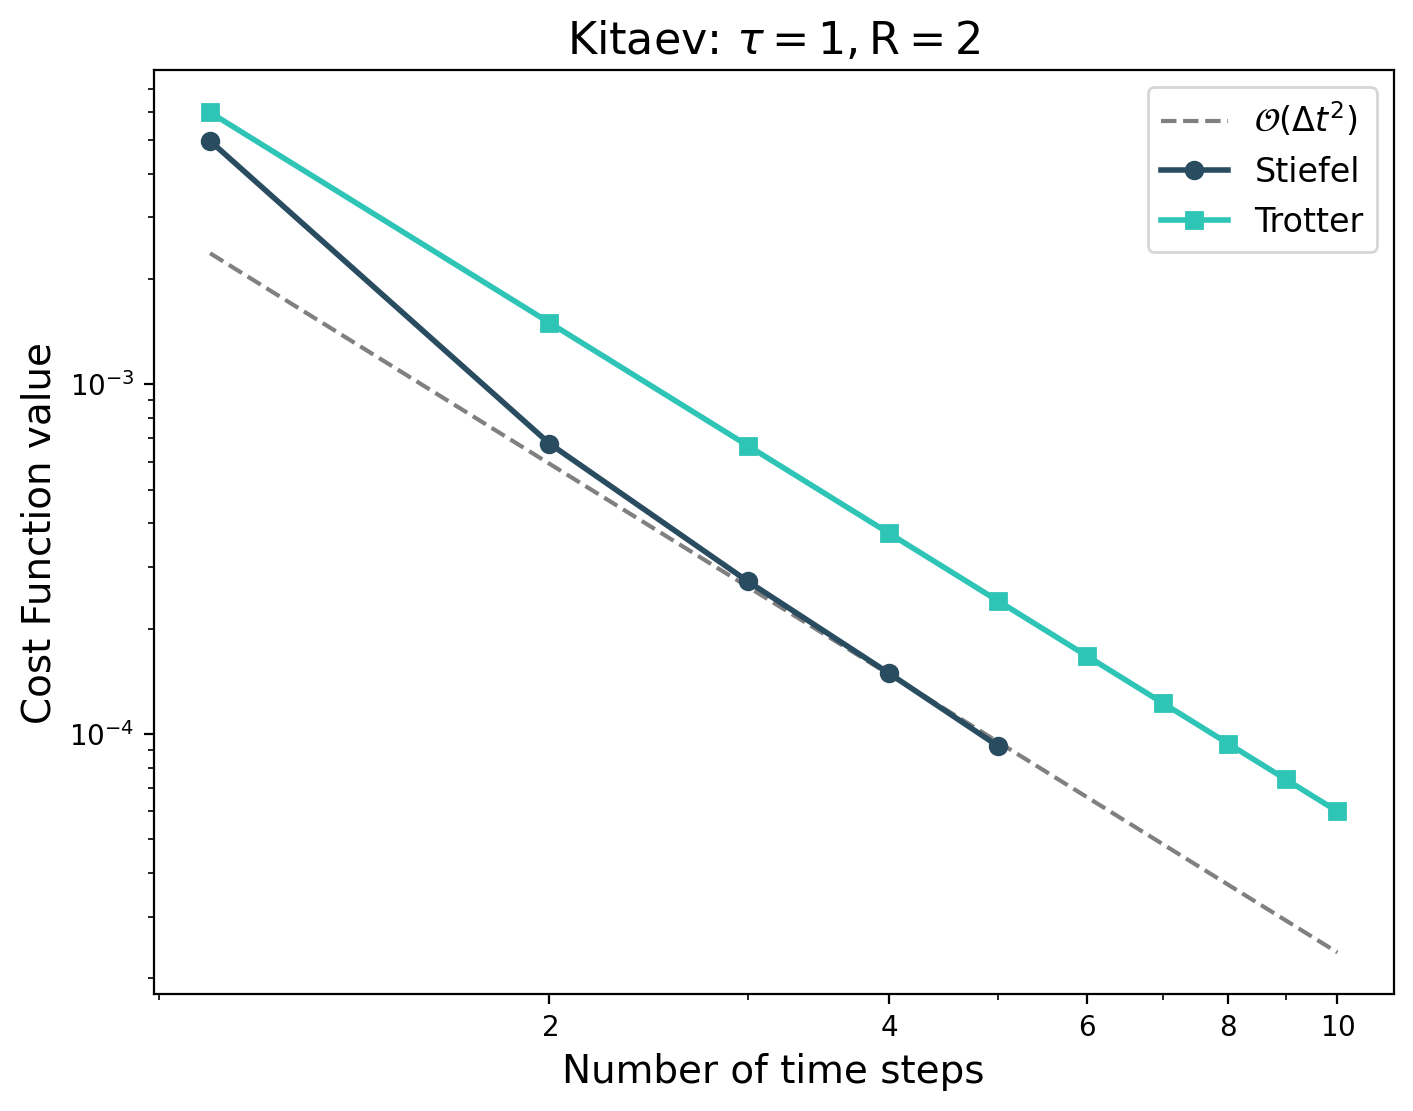

In [78]:
a = 7.5**(-3)
x_smooth = np.linspace(1, 10, 10)
y_smooth = a*x_smooth**(-2)

error_functions = [error_stiefel_tau_1, error_trotter]
labels = ["Stiefel", "Trotter"]
title = r"Kitaev: $\tau = 1, \mathrm{R}=2$"
fig = plot_pretty(ydatas=error_functions,
            labels=labels,
            ylabel="Cost Function value",
            title=title,
            xlabel="Number of time steps",
            loglog=True,
            idx_main=0,
            integers=True,
            legend_out=False,
            comparison_label=r"$\mathcal{O}(\Delta t^2)$",
            comparison_value=y_smooth,
            )
fig.savefig('../images/thesis/cost_kitaev_timesteps.pdf', bbox_inches='tight')

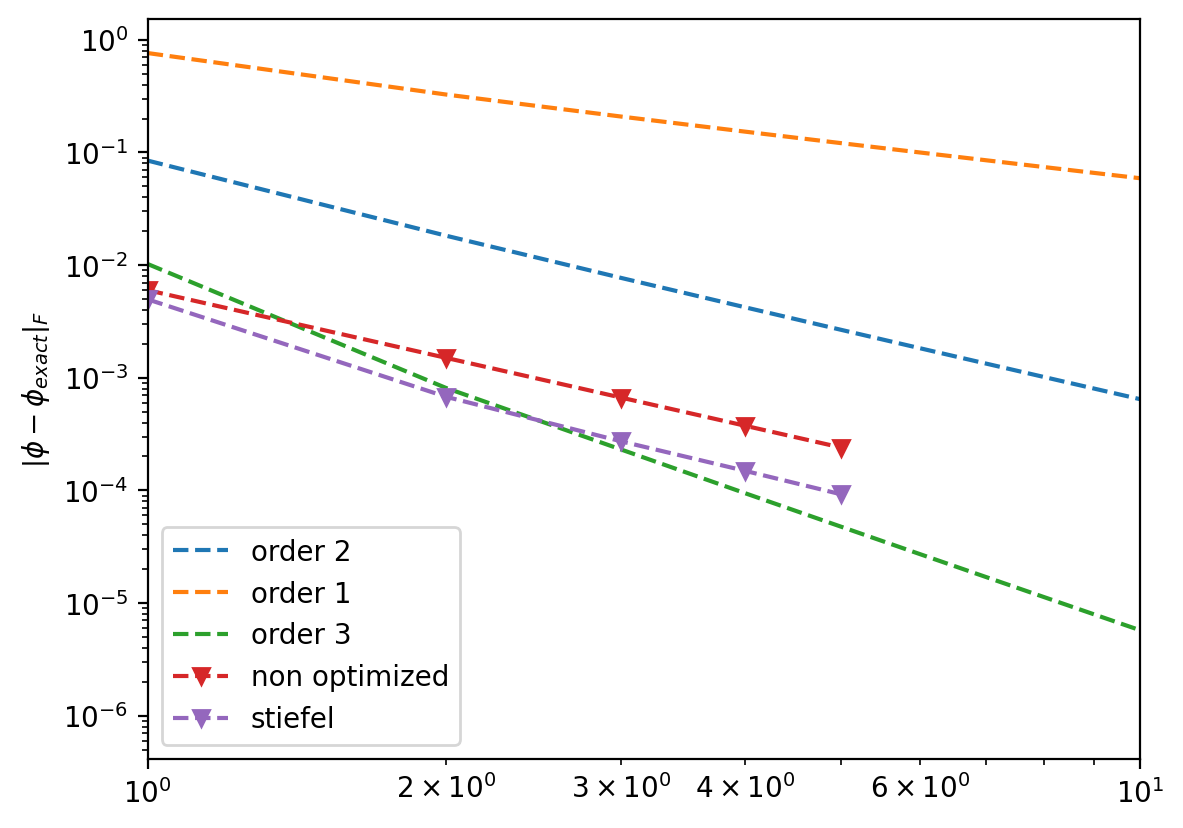

In [44]:
number_timesteps_stiefel = [1,2,3,4,5]
timesteps_stiefel = [tau/n for n in number_timesteps_stiefel]

fig = plt.figure(dpi=200)
plt.ylabel(r'$ \left| \phi - \phi_{exact} \right|_F $')
ax = plt.gca()
# plt.xlabel('timestep')
plt.xlim(1,10)

plt.loglog(number_timesteps, error_order_2, '--', label='order 2')
plt.loglog(number_timesteps, error_order_1, '--', label='order 1')
plt.loglog(number_timesteps, error_order_3, '--', label='order 3')

plt.loglog(number_timesteps_stiefel, error_nonoptimized_tau_1, '--v', label='non optimized')
exponent = -2
a = 0.006
# plt.loglog(number_timesteps_stiefel, a*np.array(number_timesteps_stiefel, dtype=float)**(exponent), '-*' ,label=fr'${a} x^{exponent}$')

plt.loglog(number_timesteps_stiefel, error_stiefel_tau_1, '--v', label='stiefel')
exponent_2 = -2.6
b = 0.005
# plt.loglog(number_timesteps_stiefel, b*np.array(number_timesteps_stiefel, dtype=float)**(exponent_2), '-*' ,label=fr'${b} x^{exponent_2}$')

plt.legend()

# Create random psd and use to compare the schemes

In [62]:
from opentn.stiefel import random_psd
from opentn.transformations import vectorize, unvectorize
from opentn.optimization import get_general_trotter_local_ansatz
from opentn.structure_preserving import random_psd_error, compute_trace_superop


In [63]:
num_timesteps_scheme = 20
superop_nonopt_ts = []
for n in range(1, num_timesteps_scheme + 1):
    xs_trotter_ts = [super2ortho(op) for op in get_general_trotter_local_ansatz(lindbladians=Lnn, tau=tau, n=n)]
    superop_nonopt_ts.append(model_stiefel_local(xs_trotter_ts, N, d))

xs_stiefel_ts = [xs_timestep_1_tau_1_opt, xs_timestep_2_tau_1_opt, xs_timestep_3_tau_1_opt, xs_timestep_4_tau_1_opt]

# stiefel optimized
superop_stiefel_ts = [model_stiefel_local(xs[-1], N, d) for xs in xs_stiefel_ts]

superop_ord_1_ts = [composition(unnormalized_scheme(lindbladians=Lnn, N=N, d=d, dt=tau/n, order=1), n=n) for n in range(1, num_timesteps_scheme + 1)]
superop_ord_2_ts = [composition(unnormalized_scheme(lindbladians=Lnn, N=N, d=d, dt=tau/n, order=2), n=n) for n in range(1, num_timesteps_scheme + 1)]
superop_ord_3_ts = [composition(unnormalized_scheme(lindbladians=Lnn, N=N, d=d, dt=tau/n, order=3, verbose=True), n=n) for n in range(1, num_timesteps_scheme + 1)]

currently using dt=1.0, M=3
currently using dt=0.5, M=3
currently using dt=0.3333333333333333, M=3
currently using dt=0.25, M=3
currently using dt=0.2, M=3
currently using dt=0.16666666666666666, M=3
currently using dt=0.14285714285714285, M=3
currently using dt=0.125, M=3
currently using dt=0.1111111111111111, M=3
currently using dt=0.1, M=3
currently using dt=0.09090909090909091, M=3
currently using dt=0.08333333333333333, M=3
currently using dt=0.07692307692307693, M=3
currently using dt=0.07142857142857142, M=3
currently using dt=0.06666666666666667, M=3
currently using dt=0.0625, M=3
currently using dt=0.058823529411764705, M=3
currently using dt=0.05555555555555555, M=3
currently using dt=0.05263157894736842, M=3
currently using dt=0.05, M=3


In [64]:
error_nonopt_unnorm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_nonopt_ts, normalize=False)
error_stiefel_unnorm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_stiefel_ts, normalize=False)

error_order_1_unnorm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_ord_1_ts, normalize=False)
error_order_2_unnorm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_ord_2_ts, normalize=False)
error_order_3_unnorm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_ord_3_ts, normalize=False)
errors_unnorm = [error_nonopt_unnorm, error_stiefel_unnorm, error_order_1_unnorm, error_order_2_unnorm, error_order_3_unnorm]

In [65]:
error_nonopt_norm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_nonopt_ts, normalize=True)
error_stiefel_norm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_stiefel_ts, normalize=True)

error_order_1_norm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_ord_1_ts, normalize=True)
error_order_2_norm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_ord_2_ts, normalize=True)
error_order_3_norm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_ord_3_ts, normalize=True)

errors_norm = [error_nonopt_norm, error_stiefel_norm, error_order_1_norm, error_order_2_norm, error_order_3_norm]

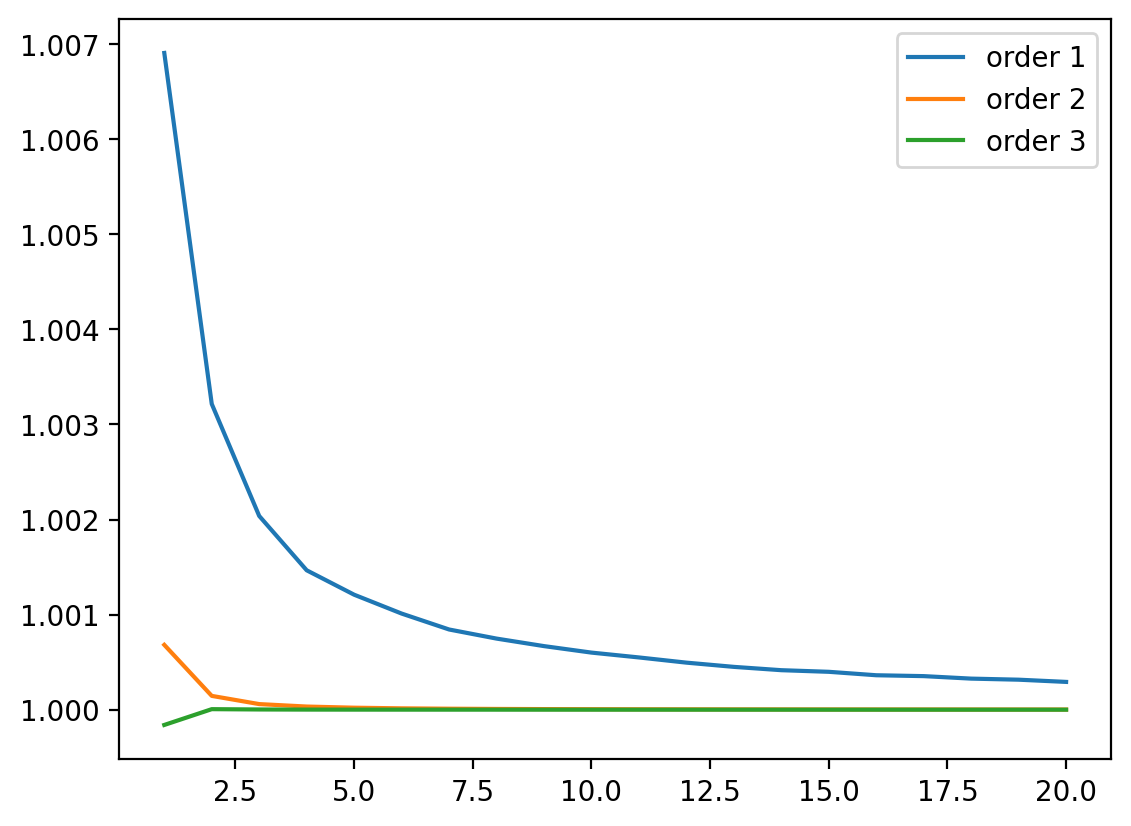

In [66]:
# testing out the traces of the unnormalized schemes
traces_ord_1 = []
traces_ord_2 = []
traces_ord_3 = []

for superop in superop_ord_1_ts:
    traces_ord_1.append(compute_trace_superop(superop))

for superop in superop_ord_2_ts:
    traces_ord_2.append(compute_trace_superop(superop))

for superop in superop_ord_3_ts:
    traces_ord_3.append(compute_trace_superop(superop))
    
fig = plt.figure(dpi=200)
plt.plot(range(1, len(traces_ord_1) + 1), traces_ord_1, label='order 1')
plt.plot(range(1, len(traces_ord_2) + 1), traces_ord_2, label='order 2')
plt.plot(range(1, len(traces_ord_3) + 1), traces_ord_3, label='order 3')
plt.legend()

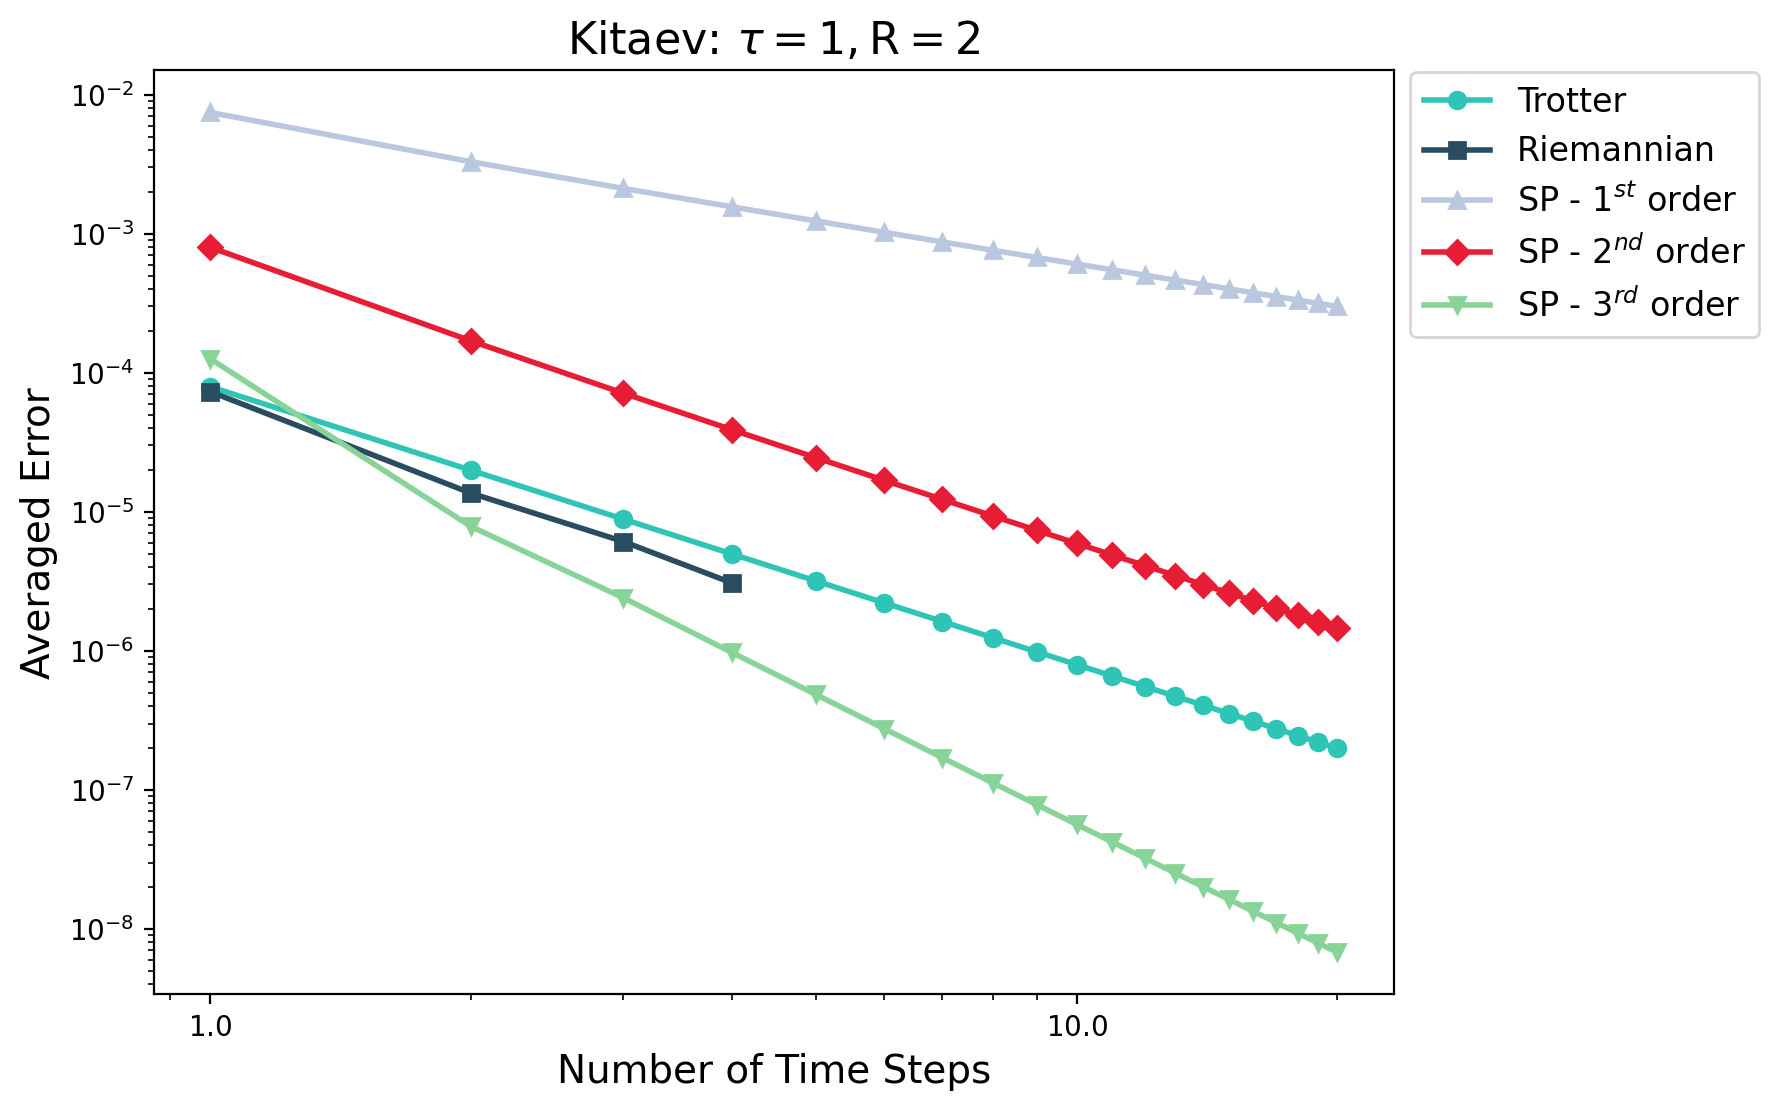

In [74]:
labels = ['Trotter', 'Riemannian', r'SP - $1^{st}$ order', r'SP - $2^{nd}$ order', r'SP - $3^{rd}$ order', r'SP - $4^{th}$ order'][:]
title = r"Kitaev: $\tau = 1, \mathrm{R}=2$"

fig = plot_pretty(
    errors_norm,
    labels=labels,
    ylabel="Averaged Error",
    xlabel="Number of Time Steps",
    title=title,
    loglog=True,
    integers=False,
    idx_main=1,
    )
fig.savefig('../images/thesis/final_comparison_kitaev.pdf', bbox_inches='tight')

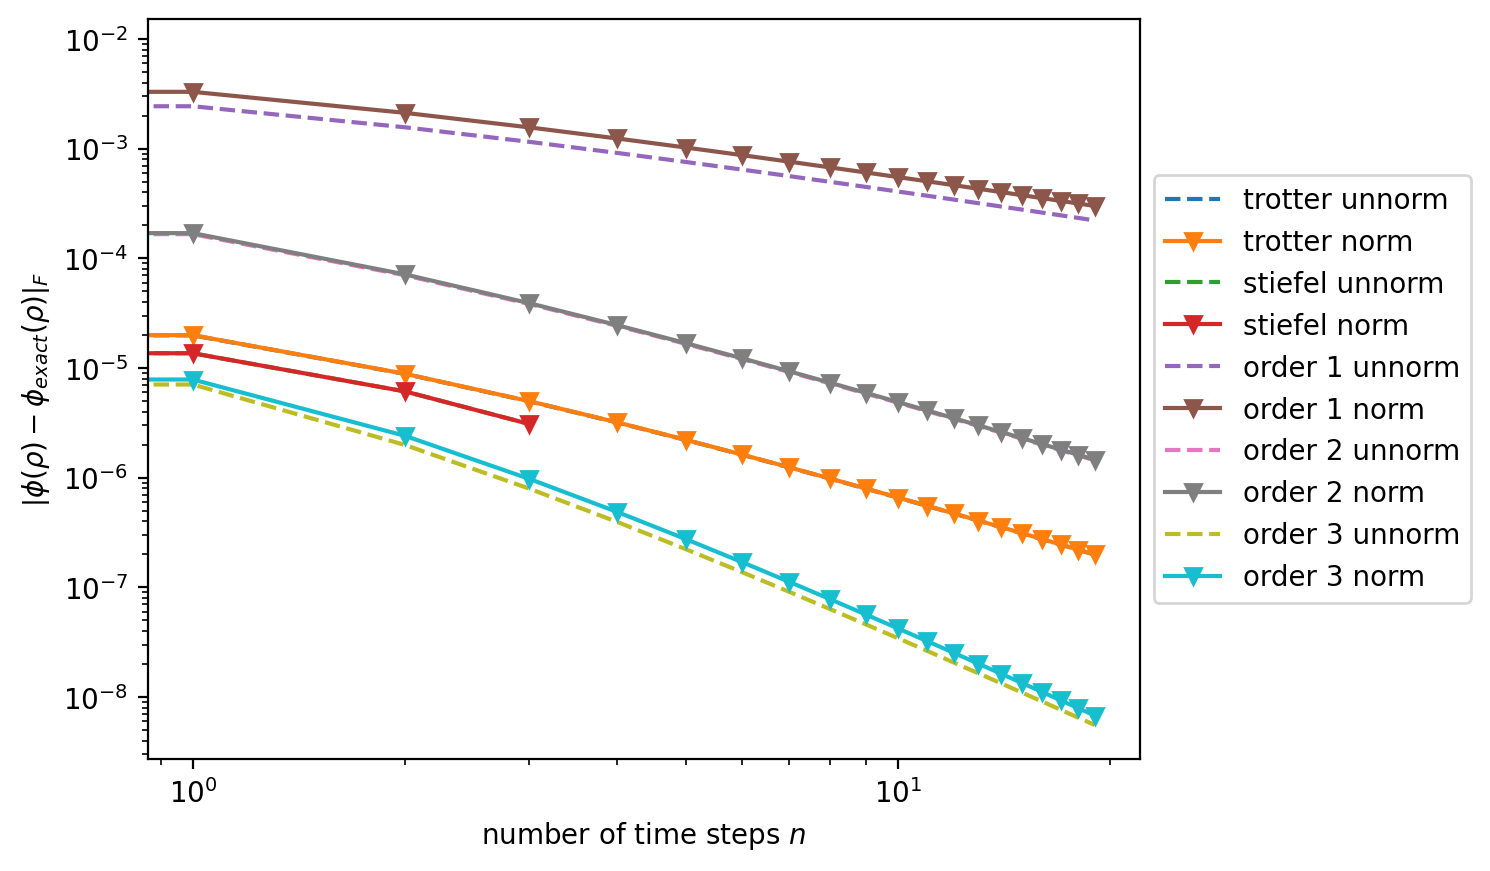

In [67]:
# without dividing by the trace
labels = ['trotter', 'stiefel', 'order 1', 'order 2', 'order 3']
fig = plt.figure(dpi=200)
plt.ylabel(r'$ \left| \phi(\rho) - \phi_{exact}(\rho) \right|_F $')
plt.xlabel('number of time steps $n$')
for i, (unnorm, norm) in enumerate(zip(errors_unnorm, errors_norm)):
    plt.loglog(unnorm, '--', label=labels[i] + ' unnorm')
    plt.loglog(norm, '-v', label=labels[i] + ' norm')
# Place the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

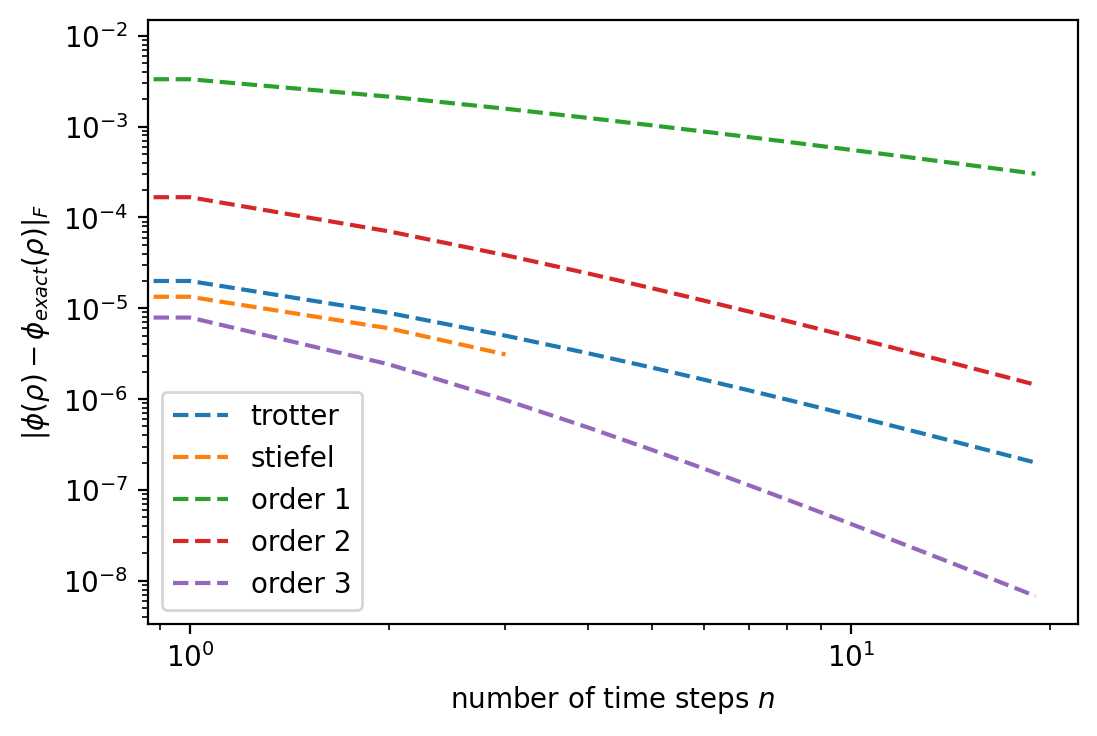

In [440]:
labels = ['trotter', 'stiefel', 'order 1', 'order 2', 'order 3']
fig = plt.figure(dpi=200)
plt.ylabel(r'$ \left| \phi(\rho) - \phi_{exact}(\rho) \right|_F $')
plt.xlabel('number of time steps $n$')
for i in range(len(errors_norm)):
    plt.loglog(errors_norm[i], '--', label=labels[i])
plt.legend()
# set_discrete_labels(labels=[str(ts+1) for ts in range(num_timesteps_scheme)], rotation=0)

In [464]:
from opentn.structure_preserving import generate_indices_ks, check_indices_ks, generate_differences, generate_rj_with_multiplicity
# Example usage:
n = 2
m = 3
ks_list = generate_indices_ks(n, m)
for ks in ks_list:
    check_indices_ks(ks, m)

# Example usage:
numbers = [0, 1, 3, 6, 10, 15]
print(generate_differences(numbers))

# generate_rj_with_multiplicity(rj_list=[1,2,3,4,5], ks=[2,3])

[1, 2, 3, 4, 5]


In [453]:
# from opentn.structure_preserving import choose_nm, generate_rj, generate_rjs_subsets

# taus = np.logspace(start=2, stop=-9, num=12, base=2)[::-1]
# print('taus: ', taus)
# for tau in taus[:]:
#     print(choose_nm(m=1, M=3, dt=tau))

# Nm = 262144
# m = 1
# dt = 1.953125e-03
# rj_all = generate_rj(Nm=Nm, dt=dt)
# for n in range(1, min(m, Nm) + 1):
#     print('n: ', n)
#     ks_list = generate_indices_ks(n=n, m=m)
#     print(ks_list)
#     rj_subsets = generate_rjs_subsets(rj_all=rj_all, n=n)
#     print('rj: ', rj_subsets)

# number_timesteps = list(range(1,20))
# tau = 1
# for n in number_timesteps:
#     print(choose_nm(m=1, M=3, dt=tau/n))